# **Installation of essential libraries for remote sensing, land cover analysis and importing them**

In [ ]:
!pip install rasterio earthpy numpy matplotlib pandas

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from google.colab import files
from google.colab import drive
import earthpy.plot as ep
import os
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.2 MB/s eta 0:00:00


# **Functions to upload multispectral images and apply basic preprocessing**

In [ ]:
# Function to upload images
def upload_image(prompt):
    print(prompt)
    uploaded = files.upload()

    # Check if a file was uploaded
    if not uploaded:
        print("No file was uploaded.")
        return None

    # Get the file name
    file_name = next(iter(uploaded.keys()))

    # Validate file extension
    if file_name.lower().endswith(('.tif', '.tiff')):
        return file_name
    else:
        print(f"Invalid file type: {file_name}. Please upload a .TIF or .TIFF file.")
        return None

def read_and_preprocess(image_path):
    with rasterio.open(image_path) as src:
        # Read all bands from the multispectral image
        image = src.read()  # shape will be (bands, height, width)

        # Move the bands axis to the last position (height, width, bands)
        image = np.moveaxis(image, 0, -1)

    # Normalize the image
    image_normalized = image.astype(np.float32) / 255.0

    return image_normalized

# **Calculation of vegetation index, water index and built-up index from images**

In [ ]:
# Function to calculate NDVI
def calculate_ndvi(image):
    # Check for at least 5 bands
    if image.shape[2] >= 5:
        nir = image[:, :, 3]  # NIR band (B5)
        red = image[:, :, 2]  # Red band (B4)
    else:
        print("Insufficient bands for NDVI calculation")
        return None

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red + 1e-8)
    return ndvi

# Function to calculate NDWI
def calculate_ndwi(image):
    # Check for at least 5 bands
    if image.shape[2] >= 5:
        green = image[:, :, 1]  # Green band (B3)
        nir = image[:, :, 3]    # NIR band (B5)
    else:
        print("Insufficient bands for NDWI calculation")
        return None

    # Calculate NDWI
    ndwi = (green - nir) / (green + nir + 1e-8)
    return ndwi

# Function to calculate NDBI
def calculate_ndbi(image):
    # Check for at least 5 bands
    if image.shape[2] >= 5:
        swir = image[:, :, 4]  # SWIR band (B6)
        nir = image[:, :, 3]   # NIR band (B5)
    else:
        print("Insufficient bands for NDBI calculation")
        return None

    # Calculate NDBI
    ndbi = (swir - nir) / (swir + nir + 1e-8)
    return ndbi

# **Classifying land cover into built-up areas, vegetation, forest, water bodies, and barren land using NDBI, NDVI and NDWI**

In [ ]:
def classify_land_cover(image, ndvi, ndwi, ndbi):
    # Built-up area based on NDBI
    built_up_area = (ndbi > 0).astype(float)

    # Forest based on NDVI
    forest = (ndvi > 0.5).astype(float)
    vegetation = ((ndvi > 0.1) & (ndvi <= 0.5)).astype(float) # Vegetation based on NDVI

    # Water bodies based on NDWI
    water = (ndwi > 0).astype(float)

    # Barren land based on NDVI
    barren_land = ((ndvi >= -0.1) & (ndvi <= 0.1)).astype(float)

    # Resolve conflicts by priority
    # Priority 1: Built-up areas take precedence
    vegetation[built_up_area > 0] = 0
    forest[built_up_area > 0] = 0
    barren_land[built_up_area > 0] = 0

    # Priority 2: Water bodies take precedence over vegetation, forest, and barren land
    forest[water > 0] = 0
    vegetation[water > 0] = 0
    barren_land[water > 0] = 0
    built_up_area[water > 0] = 0

    # Return individual masks for each land cover type
    return built_up_area, water, forest, vegetation, barren_land

# **Calculation of the percentage of land cover types (built-up area, water, forest, vegetation, barren land) based on classified land cover categories**

In [ ]:
def calculate_land_cover_percentages(image, ndvi, ndwi, ndbi):
    # Get the classified land cover categories
    built_up_area, water, forest, vegetation, barren_land = classify_land_cover(image, ndvi, ndwi, ndbi)

    # Total number of pixels in the image
    total_pixels = image.shape[0] * image.shape[1]

    # Calculate the percentage for each land cover type
    built_up_percent = np.sum(built_up_area) / total_pixels * 100  # Built-up Area
    water_percent = np.sum(water) / total_pixels * 100              # Water
    forest_percent = np.sum(forest) / total_pixels * 100            # Forest
    vegetation_percent = np.sum(vegetation) / total_pixels * 100    # Vegetation
    barren_land_percent = np.sum(barren_land) / total_pixels * 100  # Barren Land

    # Return the percentages for all categories as a dictionary for clarity
    return {
        "Built-up Area": built_up_percent,
        "Water": water_percent,
        "Forest": forest_percent,
        "Vegetation": vegetation_percent,
        "Barren Land": barren_land_percent
    }

# **Function to compare land cover changes between two images and generate a change map**

In [ ]:
def urban_change_detection(image1, image2, ndvi1, ndvi2, ndwi1, ndwi2, ndbi1, ndbi2, change_threshold=0.1):
    # Classify land cover for both images using NDVI, NDWI and NDBI
    built_up1, water1, forest1, vegetation1, barren_land1 = classify_land_cover(image1, ndvi1, ndwi1, ndbi1)
    built_up2, water2, forest2, vegetation2, barren_land2 = classify_land_cover(image2, ndvi2, ndwi2, ndbi2)

    # Calculate total pixel counts for both images
    total_pixels = image1.shape[0] * image1.shape[1]

    # Calculate percentage changes for each land cover category
    change_built_up = np.abs(np.sum(built_up2) - np.sum(built_up1)) / total_pixels
    change_water = np.abs(np.sum(water2) - np.sum(water1)) / total_pixels
    change_forest = np.abs(np.sum(forest2) - np.sum(forest1)) / total_pixels
    change_vegetation = np.abs(np.sum(vegetation2) - np.sum(vegetation1)) / total_pixels
    change_barren_land = np.abs(np.sum(barren_land2) - np.sum(barren_land1)) / total_pixels

    # Initialize a change map (binary: 1 for changes, 0 for no changes)
    change_map = np.zeros(image1.shape[:2], dtype=np.uint8)

    # Apply change thresholds on each category for creating a change map
    if change_built_up > change_threshold:
        change_map[built_up2 > 0] = 1  # Mark areas as changed where built-up area increased

    if change_water > change_threshold:
        change_map[water2 > 0] = 1  # Mark areas as changed where water bodies increased

    if change_forest > change_threshold:
        change_map[forest2 > 0] = 1  # Mark areas as changed where forest area increased

    if change_vegetation > change_threshold:
        change_map[vegetation2 > 0] = 1  # Mark areas as changed where vegetation increased

    if change_barren_land > change_threshold:
        change_map[barren_land2 > 0] = 1  # Mark areas as changed where barren land increased

    # Convert change_map to binary for visualization
    change_map = change_map * 255  # Scale to 255 for visualization

    return change_map

# **Prompts user to upload two images, then reads and preprocesses them for further analysis**

In [ ]:
# Upload images
image1_path = upload_image("Upload image-1:")
if not image1_path:
    raise Exception("Failed to upload the first image.")

# Upload Image 2
image2_path = upload_image("Upload image-2:")
if not image2_path:
    raise Exception("Failed to upload the second image.")

# Return the uploaded image paths
image_paths = [image1_path, image2_path]
print(f"Uploaded images:\nImage 1: {image1_path}\nImage 2: {image2_path}")

if image_paths:  # Check if the images were successfully found
    # Read and preprocess the images
    image1 = read_and_preprocess(image_paths[0])
    image2 = read_and_preprocess(image_paths[1])

    # Check if images were successfully read and preprocessed
    if image1 is not None and image2 is not None:
        print("Images successfully uploaded and preprocessed.")
    else:
        print("Failed to upload or preprocess the images.")
else:
    print("Failed to upload the images.")

Upload image-1:


Saving L8_Vijayawada2016.tif to L8_Vijayawada2016.tif
Upload image-2:


Saving L8_Vijayawada2023.tif to L8_Vijayawada2023.tif
Uploaded images:
Image 1: L8_Vijayawada2016.tif
Image 2: L8_Vijayawada2023.tif
Images successfully uploaded and preprocessed.


# **Calculates NDVI, NDWI and NDBI for both uploaded images to analyze vegetation, water and built-up area**

In [ ]:
# Calculate NDVI, NDWI and NDBI for both images
ndvi1 = calculate_ndvi(image1)
ndvi2 = calculate_ndvi(image2)

ndwi1 = calculate_ndwi(image1)
ndwi2 = calculate_ndwi(image2)

ndbi1 = calculate_ndbi(image1)
ndbi2 = calculate_ndbi(image2)

# **Performs urban change detection and visualizes the changes between two images by displaying a change map**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


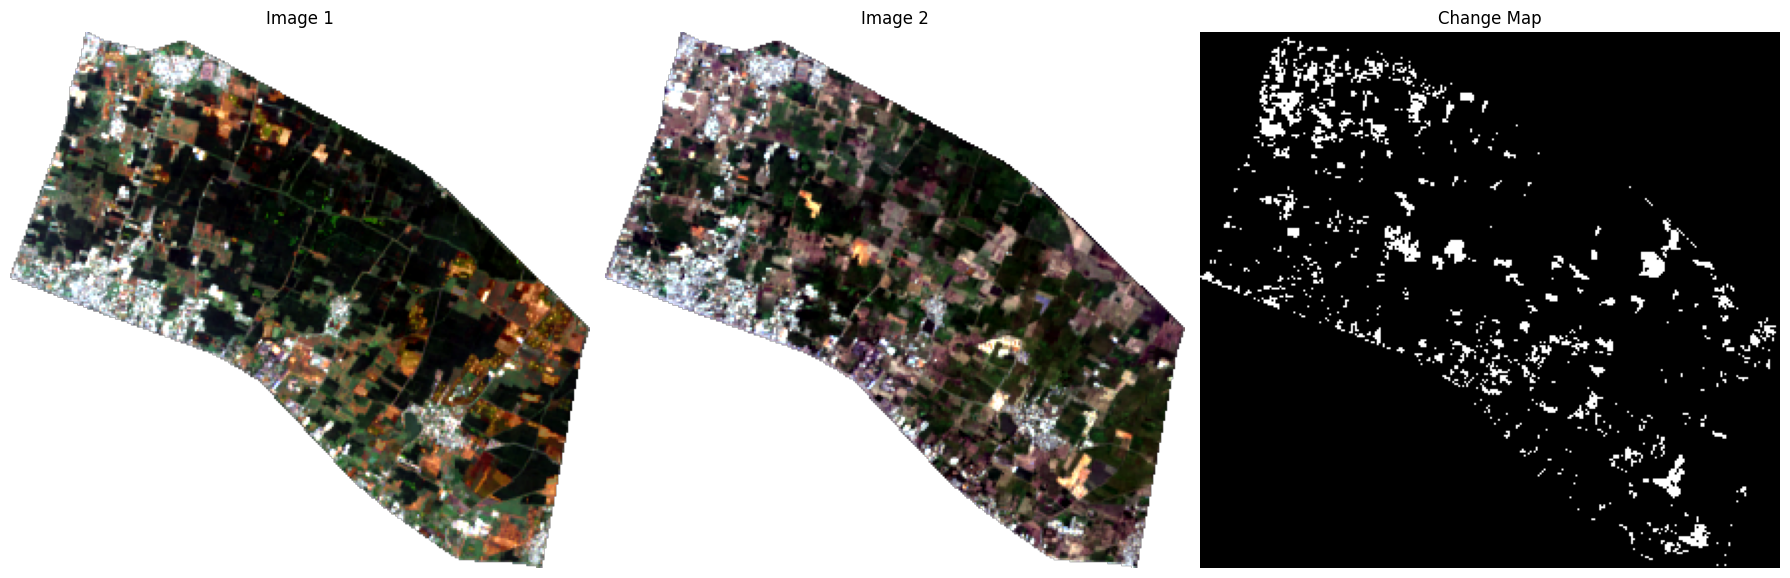

In [ ]:
drive.mount('/content/drive')

# Perform urban change detection
change_map = urban_change_detection(image1, image2, ndvi1, ndvi2, ndwi1, ndwi2, ndbi1, ndbi2)

# Initialize the change map (black = no change)
change_map = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

# Define white color for changes and black for no change
color_change = [255, 255, 255]  # White for changes
color_no_change = [0, 0, 0]      # Black for no change (default)

# Get the classified land cover for both images
built_up1, water1, forest1, vegetation1, barren_land1 = classify_land_cover(image1, ndvi1, ndwi1, ndbi1)
built_up2, water2, forest2, vegetation2, barren_land2 = classify_land_cover(image2, ndvi2, ndwi2, ndbi2)

# Threshold to detect significant changes
change_threshold = 0.1  # Can be adjusted

# Create change maps for each land cover type
built_up_change = (np.abs(built_up2 - built_up1) > change_threshold)
water_change = (np.abs(water2 - water1) > change_threshold)
forest_change = (np.abs(forest2 - forest1) > change_threshold)
vegetation_change = (np.abs(vegetation2 - vegetation1) > change_threshold)
barren_land_change = (np.abs(barren_land2 - barren_land1) > change_threshold)

# Combine all the changes into one map
total_change = built_up_change | water_change | forest_change | vegetation_change | barren_land_change

# Apply the color for changes (white) and no changes (black)
change_map[total_change] = color_change
change_map[~total_change] = color_no_change

# Load the images for displaying
src1 = rasterio.open('/content/drive/MyDrive/spectral/L8_Vijayawada2016.tif')
src2 = rasterio.open('/content/drive/MyDrive/spectral/L8_Vijayawada2023.tif')

# Create a figure with 3 subplots
plt.figure(figsize=(18, 6))

# Display Image 1
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first position
ep.plot_rgb(src1.read(), rgb=[2, 1, 0], ax=plt.gca(), title="Image 1", stretch=True)
plt.axis('off')

# Display Image 2
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second position
ep.plot_rgb(src2.read(), rgb=[2, 1, 0], ax=plt.gca(), title="Image 2", stretch=True)
plt.axis('off')

# Display the change map
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third position
plt.imshow(change_map)
plt.title('Change Map')
plt.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# **Generation of a change matrix by analyzing the changes in land cover and displaying a change matrix**

In [ ]:
# Calculate land cover percentages for both images
land_cover1 = calculate_land_cover_percentages(image1, ndvi1, ndwi1, ndbi1)
land_cover2 = calculate_land_cover_percentages(image2, ndvi2, ndwi2, ndbi2)

# Create a DataFrame to show changes in land cover
data = {
    'Category': ['Built-up Area', 'Water', 'Forest', 'Vegetation', 'Barren Land'],
    'Image 1 (%)': [land_cover1["Built-up Area"], land_cover1["Water"], land_cover1["Forest"],
                    land_cover1["Vegetation"], land_cover1["Barren Land"]],
    'Image 2 (%)': [land_cover2["Built-up Area"], land_cover2["Water"], land_cover2["Forest"],
                    land_cover2["Vegetation"], land_cover2["Barren Land"]],
    'Change (%)': [land_cover2["Built-up Area"] - land_cover1["Built-up Area"],
                   land_cover2["Water"] - land_cover1["Water"],
                   land_cover2["Forest"] - land_cover1["Forest"],
                   land_cover2["Vegetation"] - land_cover1["Vegetation"],
                   land_cover2["Barren Land"] - land_cover1["Barren Land"]]
}

# Calculate the total change percentage from the change map
change_map_gray = change_map.astype(np.uint8)
change_map_gray = change_map[:, :, 0]

# Calculate the number of changed and unchanged pixels
changed_pixels = np.sum(change_map_gray == 255)  # 255 represents changes (white color)
total_pixels = change_map_gray.size

# Calculate the percentage of changed and unchanged areas
change_percentage = (changed_pixels / total_pixels) * 100
unchanged_percentage = 100 - change_percentage

# Prepare the change matrix for detailed analysis
change_matrix = np.array([[land_cover1["Built-up Area"], land_cover2["Built-up Area"], land_cover2["Built-up Area"] - land_cover1["Built-up Area"]],
                          [land_cover1["Water"], land_cover2["Water"], land_cover2["Water"] - land_cover1["Water"]],
                          [land_cover1["Forest"], land_cover2["Forest"], land_cover2["Forest"] - land_cover1["Forest"]],
                          [land_cover1["Vegetation"], land_cover2["Vegetation"], land_cover2["Vegetation"] - land_cover1["Vegetation"]],
                          [land_cover1["Barren Land"], land_cover2["Barren Land"], land_cover2["Barren Land"] - land_cover1["Barren Land"]]])

# Create a DataFrame for the change matrix
change_matrix_df = pd.DataFrame(change_matrix, columns=['Image at time-1(2016)', 'Image at time-2(2023)', 'Change (%)'],
                                index=['Built-up Area', 'Water', 'Forest', 'Vegetation', 'Barren Land'])

# Display the change matrix
print("Change Matrix:")
print(change_matrix_df.round(2))  # Round for readability

# Display the overall change analysis
print(f"\nChanged Area (All Categories): {change_percentage:.2f}%")
print(f"Unchanged Area: {unchanged_percentage:.2f}%")

Change Matrix:
               Image at time-1(2016)  Image at time-2(2023)  Change (%)
Built-up Area                   1.74                   4.50        2.75
Water                           0.05                   0.07        0.03
Forest                          0.01                   0.00       -0.01
Vegetation                     50.07                  47.22       -2.85
Barren Land                     0.04                   0.11        0.08

Changed Area (All Categories): 4.85%
Unchanged Area: 95.15%


# **Visualizing the changes in land cover by plotting a graph  for different land cover categories**

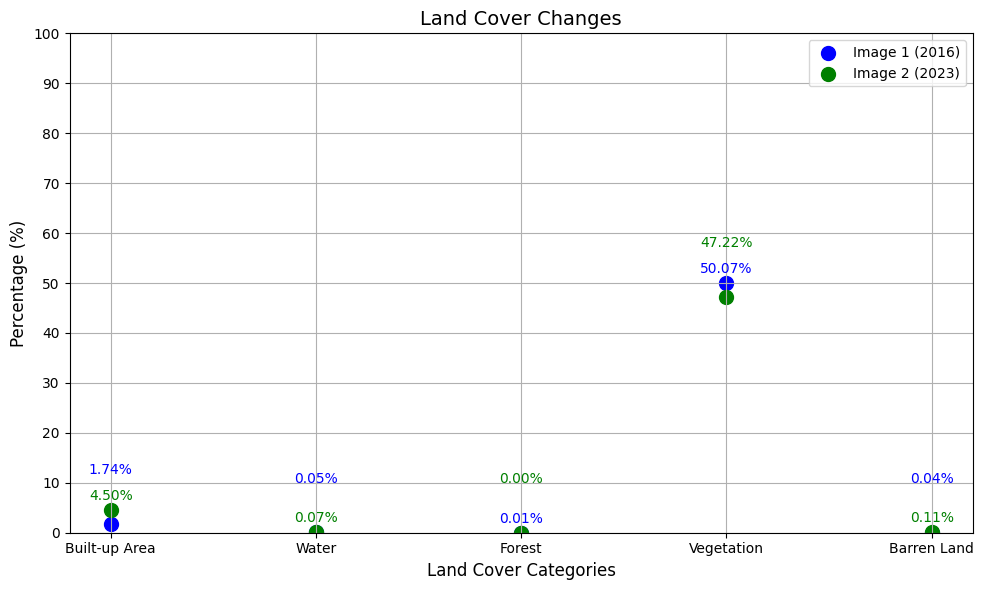

In [ ]:
# Categories of land cover
categories = ['Built-up Area', 'Water', 'Forest', 'Vegetation', 'Barren Land']

# Percentages from Image 1 and Image 2
image1_percentages = [land_cover1["Built-up Area"], land_cover1["Water"], land_cover1["Forest"],
                      land_cover1["Vegetation"], land_cover1["Barren Land"]]
image2_percentages = [land_cover2["Built-up Area"], land_cover2["Water"], land_cover2["Forest"],
                      land_cover2["Vegetation"], land_cover2["Barren Land"]]

# Plotting the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for Image 1
plt.scatter(categories, image1_percentages, marker='o', label='Image 1 (2016)', color='blue', s=100)

# Scatter plot for Image 2
plt.scatter(categories, image2_percentages, marker='o', label='Image 2 (2023)', color='green', s=100)

# Adding labels and title
plt.xlabel('Land Cover Categories', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Land Cover Changes', fontsize=14)

# Set y-axis scale to 0-100 with intervals of 10
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))  # Y-axis ticks at intervals of 10

# Display values at each point, dynamically adjusting label positions to avoid overlap
for i, category in enumerate(categories):
    if image1_percentages[i] > image2_percentages[i]:
        plt.text(i, image1_percentages[i] + 2, f'{image1_percentages[i]:.2f}%', color='blue', ha='center', fontsize=10)
        plt.text(i, image2_percentages[i] + 10, f'{image2_percentages[i]:.2f}%', color='green', ha='center', fontsize=10)
    else:
        plt.text(i, image1_percentages[i] + 10, f'{image1_percentages[i]:.2f}%', color='blue', ha='center', fontsize=10)
        plt.text(i, image2_percentages[i] + 2, f'{image2_percentages[i]:.2f}%', color='green', ha='center', fontsize=10)

# Show gridlines for better visualization
plt.grid(True)

# Adding a legend to distinguish between Image 1 and Image 2
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()